In [3]:
# import packages
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import matplotlib.pyplot as plt
import torchvision.models as models
# This is for the progress bar.
# ! pip install tqdm
from tqdm import tqdm
# ! pip install seaborn
import seaborn as sns
# if you don't have d2l, you can use the following code to install it.
# !pip install d2l==0.17.5
# d2l is a package used to dynamically display the loss drop
from d2l import torch as d2l
# ! pip install torchsummary
from torchsummary import summary


     |████████████████████████████████| 288 kB 2.6 MB/s eta 0:00:01


We should process the data at first.

In [2]:
# Read from the csv file and take a look at the data labels.
labels_dataframe = pd.read_csv('../leaves data/train.csv')
labels_dataframe.head(5)

,image,label
0,images/0.jpg,maclura_pomifera
1,images/1.jpg,maclura_pomifera
2,images/2.jpg,maclura_pomifera
3,images/3.jpg,maclura_pomifera
4,images/4.jpg,maclura_pomifera


In [3]:
labels_dataframe.describe()

,image,label
count,18353,18353
unique,18353,176
top,images/0.jpg,maclura_pomifera
freq,1,353


Take a look at the distribution of the labels.

In [4]:
# Sort the label by the number of samples from high to low.
leaves_labels = sorted(list(set(labels_dataframe['label'])))
n_classes = len(leaves_labels)
print(n_classes)
leaves_labels[:10]

176


['abies_concolor',
 'abies_nordmanniana',
 'acer_campestre',
 'acer_ginnala',
 'acer_griseum',
 'acer_negundo',
 'acer_palmatum',
 'acer_pensylvanicum',
 'acer_platanoides',
 'acer_pseudoplatanus']

Assign different numbers to different labels

In [5]:
# Create a dictionary to map the label to the index.
class_to_num = dict(zip(leaves_labels, range(n_classes)))
class_to_num

{'abies_concolor': 0,
 'abies_nordmanniana': 1,
 'acer_campestre': 2,
 'acer_ginnala': 3,
 'acer_griseum': 4,
 'acer_negundo': 5,
 'acer_palmatum': 6,
 'acer_pensylvanicum': 7,
 'acer_platanoides': 8,
 'acer_pseudoplatanus': 9,
 'acer_rubrum': 10,
 'acer_saccharinum': 11,
 'acer_saccharum': 12,
 'aesculus_flava': 13,
 'aesculus_glabra': 14,
 'aesculus_hippocastamon': 15,
 'aesculus_pavi': 16,
 'ailanthus_altissima': 17,
 'albizia_julibrissin': 18,
 'amelanchier_arborea': 19,
 'amelanchier_canadensis': 20,
 'amelanchier_laevis': 21,
 'asimina_triloba': 22,
 'betula_alleghaniensis': 23,
 'betula_jacqemontii': 24,
 'betula_lenta': 25,
 'betula_nigra': 26,
 'betula_populifolia': 27,
 'broussonettia_papyrifera': 28,
 'carpinus_betulus': 29,
 'carpinus_caroliniana': 30,
 'carya_cordiformis': 31,
 'carya_glabra': 32,
 'carya_ovata': 33,
 'carya_tomentosa': 34,
 'castanea_dentata': 35,
 'catalpa_bignonioides': 36,
 'catalpa_speciosa': 37,
 'cedrus_atlantica': 38,
 'cedrus_deodara': 39,
 'cedru

At last we need to transform the index into the labels.

In [6]:
num_to_class = {v : k for k, v in class_to_num.items()}

See the size of top 20 photos

In [7]:
data_file_path = '../leaves data/'

transform = transforms.Compose([
    transforms.ToTensor(),
])

# see the size of top 20 images
for i in range(20):
    img = Image.open(data_file_path+labels_dataframe['image'][i])
    print(transform(img).shape)

torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


Since we want to use the pretrained ResNet model, so we do not need to resize the images.

Create a dataset for the training, validation and test.

In [8]:
class TrainData(Dataset):
    def __init__(self, csv_path, file_path):
        """
        Args:
            csv_path (string): csv file path.
            img_path (string): image file path.
        """

        self.file_path = file_path

        # read the csv file
        self.data_info = pd.read_csv(csv_path, header=None)  
        
        # caculate the length so that we can split the data into train and valid
        self.data_len = len(self.data_info.index) - 1
        
        # From above we can see the first column is the name of image
        self.image = np.asarray(self.data_info.iloc[1:, 0])
        # The second column is the label
        self.label = np.asarray(self.data_info.iloc[1:, 1])

        self.dataset_len = len(self.image)

    def __getitem__(self, index):
        # Get the image depending on the index in csv file
        image_name = self.image[index]
        img = Image.open(self.file_path + image_name)

        transform = transforms.Compose([
            transforms.ToTensor()
        ])
        
        img = transform(img)
        
        label = self.label[index]
        # number label
        number_label = class_to_num[label]

        return img, number_label 

    def __len__(self):
        return self.dataset_len


Create training dataset.

In [9]:
train_path = '../leaves data/train.csv'
img_path = '../leaves data/'

train_dataset = TrainData(train_path, img_path)

Create validation dataset.

In [10]:
valid_len = int(len(train_dataset) * 0.2)
train_len = len(train_dataset) - valid_len
train_dataset, valid_dataset = torch.utils.data.dataset.random_split(train_dataset, [train_len, valid_len])

Create the data loader for the training and testing dataset.

In [11]:
train_loader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=8, 
        shuffle=False,
        num_workers=5
    )
valid_loader = torch.utils.data.DataLoader(
        dataset=valid_dataset,
        batch_size=8,
        shuffle=False,
        num_workers=5
    )

Show the images and labels in the training dataset.

In [12]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5): 
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            ax.imshow(img.numpy())
        else:
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

In [13]:
def get_leaves_labels(labels):  
    text_labels = [leaves_labels[int(i)] for i in labels]
    return text_labels

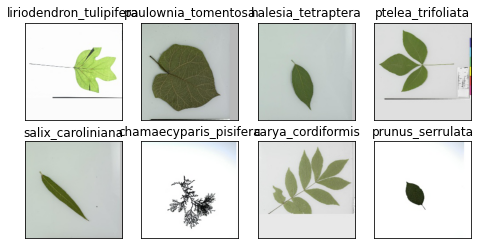

In [14]:
batch = iter(train_loader).next()
imgs = (batch[0][0:8].permute(0, 2, 3, 1))
show_images(imgs, 2, 4, titles= get_leaves_labels(batch[1]), scale=2);

See which GPU we can use.

In [15]:
def get_device():
    return 'cuda' if torch.cuda.is_available() else 'cpu'

device = get_device()
print(device)

cuda


In [16]:
!nvidia-smi

Sun Nov  6 11:06:19 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.106.00   Driver Version: 460.106.00   CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  RTX A5000           On   | 00000000:01:00.0 Off |                  Off |
| 30%   24C    P8     7W / 230W |      8MiB / 24256MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  RTX A5000           On   | 00000000:41:00.0 Off |                  Off |
| 30%   

Use the pretrained ResNet model. Since we only need to predict 176 labels, we replece the last layer with a new layer.

In [4]:
def res_model(num_classes):
    model_ft = models.resnet34()
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Sequential(nn.Linear(num_ftrs, num_classes))

    return model_ft

In [5]:
model = res_model(176)

summary(model, (3, 224, 224), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [18]:
# hyperparameters which will not change
wd = 1e-3
num_epochs = 80
model_path = '../res_model.ckpt'

In [19]:
# Initialize a model, and put it on the device specified.
model = res_model(176)
model = model.to(device)
model.device = device
# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

best_acc = 0.0

In [20]:
# This training function is used the book Dive into Deep Learning as the baseline.
def train(model, train_loader, valid_loader, criterion, num_epochs, learning_rate, weight_decay, model_path):
    optimizor = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay=weight_decay)
    criterion = criterion
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], legend=['train loss', 'train acc', 'valid acc'])
    timer, num_batches = d2l.Timer(), len(train_loader)

    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)
        model.train()
        for i, (X, y) in enumerate(train_loader):
            timer.start()
            optimizor.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizor.step()
            with torch.no_grad():
                metric.add(loss * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        valid_acc = d2l.evaluate_accuracy_gpu(model, valid_loader)
        animator.add(epoch + 1, (None, None, valid_acc))
        global best_acc
        if valid_acc > best_acc:
            best_acc = valid_acc
            torch.save(model.state_dict(), model_path)
            print('best model saved')
            
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
            f'valid acc {valid_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
            f'on {str(device)}')

Train the model with different learning rate and validation dataset to test the model.

best model saved
loss 0.221, train acc 0.959, valid acc 0.669
296.7 examples/sec on cuda


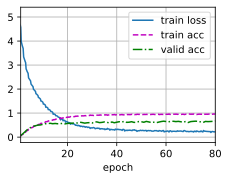

In [21]:
lr_1 = 5e-4
print('learning rate 1: {}, weight decay: {}'.format(lr_1, wd))
train(model, train_loader, valid_loader, criterion, num_epochs, lr_1, wd, model_path)  

loss 0.148, train acc 0.976, valid acc 0.689
310.0 examples/sec on cuda


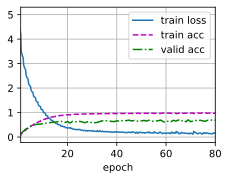

In [51]:
lr_4 = 3e-4

model = res_model(176)
model = model.to(device)
model.device = device

print('learning rate 4: {}, weight decay: {}'.format(lr_4, wd))
train(model, train_loader, valid_loader, criterion, num_epochs, lr_4, wd, model_path)  

loss 0.076, train acc 0.992, valid acc 0.720
303.2 examples/sec on cuda


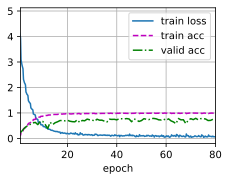

In [53]:
lr_2 = 1e-4

model = res_model(176)
model = model.to(device)
model.device = device

print('learning rate 2: {}, weight decay: {}'.format(lr_2, wd))
train(model, train_loader, valid_loader, criterion, num_epochs, lr_2, wd, model_path)

loss 0.073, train acc 0.992, valid acc 0.799
300.8 examples/sec on cuda


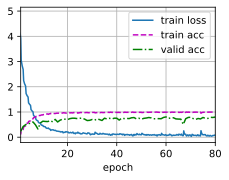

In [55]:
lr_5 = 8e-5

model = res_model(176)
model = model.to(device)
model.device = device

print('learning rate 5: {}, weight decay: {}'.format(lr_5, wd))
train(model, train_loader, valid_loader, criterion, num_epochs, lr_5, wd, model_path)

loss 0.076, train acc 0.990, valid acc 0.663
296.9 examples/sec on cuda


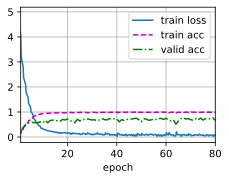

In [23]:
lr_3 = 5e-5

model = res_model(176)
model = model.to(device)
model.device = device

print('learning rate 3: {}, weight decay: {}'.format(lr_3, wd))
train(model, train_loader, valid_loader, criterion, num_epochs, lr_3, wd, model_path)

In [21]:
class Data_Aug(Dataset):
    def __init__(self, csv_path, file_path, mode='train', valid_ratio=0.2):
        """
        Args:
            csv_path (string): csv file path
            img_path (string): image file path
            mode (string): train or test
            valid_ratio (float): ratio of validation set
        """

        self.file_path = file_path
        self.mode = mode

        self.data_info = pd.read_csv(csv_path, header=None)  

        self.data_len = len(self.data_info.index) - 1
        self.train_len = int(self.data_len * (1 - valid_ratio))
        
        if mode == 'train':
            self.train_image = np.asarray(self.data_info.iloc[1:self.train_len, 0])  
            self.train_label = np.asarray(self.data_info.iloc[1:self.train_len, 1])
            self.image_arr = self.train_image 
            self.label_arr = self.train_label
        elif mode == 'valid':
            self.valid_image = np.asarray(self.data_info.iloc[self.train_len:, 0])  
            self.valid_label = np.asarray(self.data_info.iloc[self.train_len:, 1])
            self.image_arr = self.valid_image
            self.label_arr = self.valid_label
            

    def __getitem__(self, index):
        single_image_name = self.image_arr[index]

        img_as_img = Image.open(self.file_path + single_image_name)

        if self.mode == 'train':
            transform = transforms.Compose([
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomVerticalFlip(p=0.5),
                transforms.RandomRotation(30),
                transforms.ColorJitter(brightness=0.5, contrast=0, saturation=0, hue=0),
                transforms.ToTensor()
            ])
        else:
            transform = transforms.Compose([
                transforms.ToTensor()
            ])
        
        img_as_img = transform(img_as_img)
        
        label = self.label_arr[index]

        number_label = class_to_num[label]

        return img_as_img, number_label 

    def __len__(self):
        return len(self.image_arr)


In [22]:
train_data_aug_path = '../leaves data/train.csv'
img_data_aug_path = '../leaves data/'

train_dataset_aug = Data_Aug(train_data_aug_path, img_data_aug_path, mode='train')
valid_dataset_aug = Data_Aug(train_data_aug_path, img_data_aug_path, mode='valid')

In [23]:
train_loader_aug = torch.utils.data.DataLoader(
        dataset=train_dataset_aug,
        batch_size=8, 
        shuffle=False,
        num_workers=5
    )
    
valid_loader_aug = torch.utils.data.DataLoader(
        dataset=valid_dataset_aug,
        batch_size=8,
        shuffle=False,
        num_workers=5
    )

loss 0.679, train acc 0.797, valid acc 0.731
293.8 examples/sec on cuda


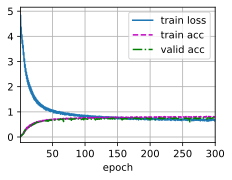

In [24]:
lr_1 = 5e-4

model = res_model(176)
model = model.to(device)
model.device = device

aug_num_epochs = 300

print('Apply data augmentation. learning rate 1: {}, weight decay: {}'.format(lr_1, wd))
train(model, train_loader_aug, valid_loader_aug, criterion, aug_num_epochs, lr_1, wd, model_path)  

loss 0.124, train acc 0.978, valid acc 0.854
293.2 examples/sec on cuda


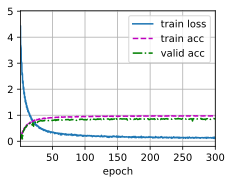

In [25]:
lr_2 = 1e-4

model = res_model(176)
model = model.to(device)
model.device = device

print('Apply data augmentation. learning rate 2: {}, weight decay: {}'.format(lr_2, wd))
train(model, train_loader_aug, valid_loader_aug, criterion, aug_num_epochs, lr_2, wd, model_path)

loss 0.079, train acc 0.987, valid acc 0.878
300.7 examples/sec on cuda


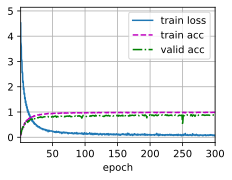

In [25]:
lr_3 = 5e-5

model = res_model(176)
model = model.to(device)
model.device = device

aug_num_epochs = 300

print('Apply data augmentation. learning rate 3: {}, weight decay: {}'.format(lr_3, wd))
train(model, train_loader_aug, valid_loader_aug, criterion, aug_num_epochs, lr_3, wd, model_path)

loss 0.356, train acc 0.904, valid acc 0.794
305.7 examples/sec on cuda


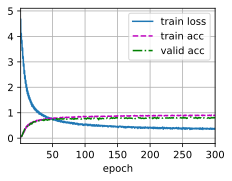

In [25]:
lr_4 = 3e-4

model = res_model(176)
model = model.to(device)
model.device = device

aug_num_epochs = 300

print('Apply data augmentation. learning rate 5: {}, weight decay: {}'.format(lr_4, wd))
train(model, train_loader_aug, valid_loader_aug, criterion, aug_num_epochs, lr_4, wd, model_path)

loss 0.112, train acc 0.980, valid acc 0.871
300.6 examples/sec on cuda


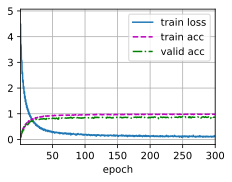

In [26]:
lr_5 = 8e-5

model = res_model(176)
model = model.to(device)
model.device = device

print('Apply data augmentation. learning rate 5: {}, weight decay: {}'.format(lr_5, wd))
train(model, train_loader_aug, valid_loader_aug, criterion, aug_num_epochs, lr_5, wd, model_path)

loss 0.077, train acc 0.989, valid acc 0.884
305.3 examples/sec on cuda


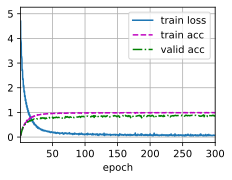

In [24]:
lr_6 = 3e-5

model = res_model(176)
model = model.to(device)
model.device = device

aug_num_epochs = 300

print('Apply data augmentation. learning rate 3: {}, weight decay: {}'.format(lr_6, wd))
train(model, train_loader_aug, valid_loader_aug, criterion, aug_num_epochs, lr_6, wd, model_path)

loss 0.055, train acc 0.993, valid acc 0.839
305.3 examples/sec on cuda


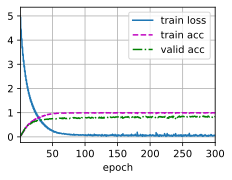

In [26]:
lr_7 = 1e-5

model = res_model(176)
model = model.to(device)
model.device = device

aug_num_epochs = 300

print('Apply data augmentation. learning rate 7: {}, weight decay: {}'.format(lr_7, wd))
train(model, train_loader_aug, valid_loader_aug, criterion, aug_num_epochs, lr_7, wd, model_path)